In [69]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon

from src.vican.cam import estimate_pose_mp
from src.vican.bipgo import bipartite_se3sync, object_bipartite_se3sync
from src.plot import plot2D, plot_cams_3D, detect_and_draw
from src.vican.dataset import Dataset

# Edit path to the folder containing the renders
DATASET_PATH = "./dataset/big_dataset"
# Edit path to the folder containing the cube calibration images.
OBJ_DATASET_PATH = "./dataset/big_dataset_object"
# Edit marker size in meters
MARKER_SIZE = 0.087                  # EDIT THIS LINE
# Check which IDs are used 
MARKER_IDS = ['10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']

dataset     = Dataset(root=DATASET_PATH)
obj_dataset = Dataset(root=OBJ_DATASET_PATH)

for k, v in dataset.cams.items():
    dataset.cams[k].distortion = np.zeros((1,12,))

for k, v in obj_dataset.cams.items():
    obj_dataset.cams[k].distortion = np.zeros((1,12,))

./dataset/big_dataset/cameras.json
Reading dataset from ./dataset/big_dataset
./dataset/big_dataset_object/cameras.json
Reading dataset from ./dataset/big_dataset_object


# Use below to rename object calib files (if needed) !!

In [ ]:
folders = os.listdir("./object-images-cangalho/")
for folder in folders:
    if os.path.isdir(os.path.join("./object-images-cangalho/", folder)):
        file = os.listdir(os.path.join("./object-images-cangalho/", folder))[0].split('.')[0]
        if file != folder:
            os.rename(os.path.join("./object-images-cangalho/", folder, file + ".png"), os.path.join("./object-images-cangalho/", folder, folder + ".png"))
        print(folder, file)

# Verify OpenCV detection

[2, 3, 4, 11]


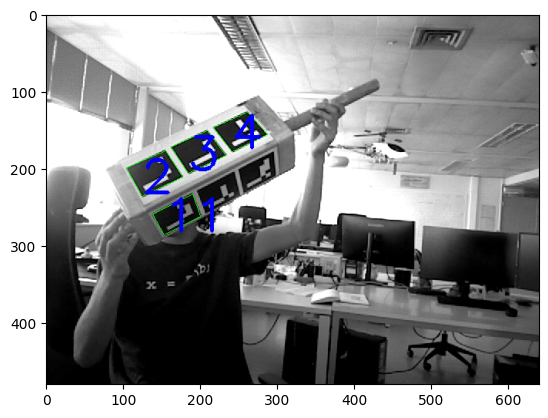

In [75]:
import cv2 as cv

im = detect_and_draw(obj_dataset.im_data['filename'][3], 'DICT_ARUCO_ORIGINAL', corner_refine='CORNER_REFINE_SUBPIX')
plt.imshow(im)

# Calibrate object

In [76]:
# This will compute camera-marker edges via PnP, in parallel
aux = estimate_pose_mp(cams=obj_dataset.im_data['cam'],
                       im_filenames=obj_dataset.im_data['filename'],
                       aruco='DICT_ARUCO_ORIGINAL',
                       marker_size=MARKER_SIZE,
                       corner_refine='CORNER_REFINE_SUBPIX',
                       marker_ids=MARKER_IDS,
                       flags='SOLVEPNP_IPPE_SQUARE',
                       brightness=-50,
                       contrast=100)

# Save it to use later, if necessary
torch.save(aux, os.path.join(OBJ_DATASET_PATH, 'cam_marker_edges.pt'))

# Optimization - see extended paper
obj_pose_est = object_bipartite_se3sync(aux,
                                        noise_model_r=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1,
                                        noise_model_t=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1,
                                        edge_filter=lambda edge : edge['reprojected_err'] < 0.2,
                                        maxiter=4,
                                        lsqr_solver="conjugate_gradient",
                                        dtype=np.float64)



Marker detection
Received 1998 images.
Started pool of 8 workers.
Merging dictionaries...
Found markers in 1995 images
Finished: 7823 markers detected.
Received graph with 2007 nodes 7823 edges
Applying constraints (0.101s).
Bipartite graph: 12 cameras, 858 timesteps, 1064 edges.
Building 12x858 adjacency and 36x2574 SO(3) sparse matrices (0.012s).
Building power graph (0.004s).


Optimizing:   0%|                                                                    | 0/4 [00:00<?, ?it/s]

Building sparse 3192x2610 incidence matrix (0.234s).
Solving sparse linear system (0.016s).
Done!


# object edges errors

0.70647365
0.52779657


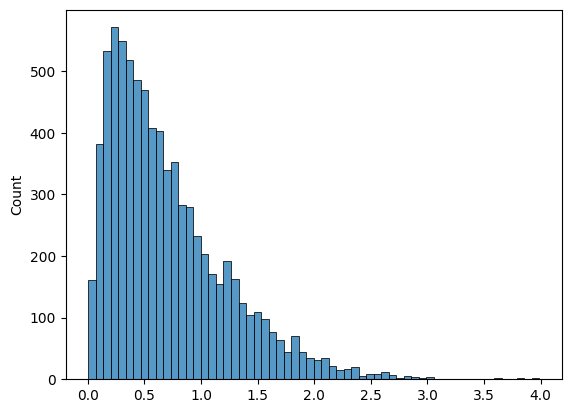

In [40]:
# plot histogram of reprojected errors
sns.histplot([edge['reprojected_err'] for edge in aux.values()])

# print the mean and std of the reprojected errors
print(np.mean([edge['reprojected_err'] for edge in aux.values()]))
print(np.std([edge['reprojected_err'] for edge in aux.values()]))

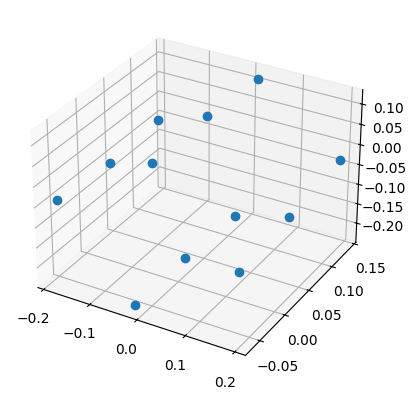

In [80]:
%matplotlib inline

xyz = np.stack([pose.inv().t() for pose in obj_pose_est.values()], axis=0)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(xyz[:,0], xyz[:,1], xyz[:,2], 'o')
plt.show()

# Detect markers & estimate camera-marker poses

In [25]:
# This will compute camera-marker edges via PnP, in parallel
cam_marker_edges = estimate_pose_mp(cams=dataset.im_data['cam'],
                                    im_filenames=dataset.im_data['filename'],
                                    aruco='DICT_ARUCO_ORIGINAL',
                                    marker_size=MARKER_SIZE,
                                    corner_refine='CORNER_REFINE_SUBPIX',
                                    marker_ids=MARKER_IDS,
                                    flags='SOLVEPNP_IPPE_SQUARE',
                                    brightness=-50,
                                    contrast=100)

# Save it to use later, if necessary
torch.save(cam_marker_edges, os.path.join(DATASET_PATH, 'cam_marker_edges.pt'))


Marker detection
Received 3747 images.
Started pool of 8 workers.
Merging dictionaries...
Found markers in 3491 images
Finished: 11735 markers detected.


# cam_marker errors

0.73733246 0.5670651


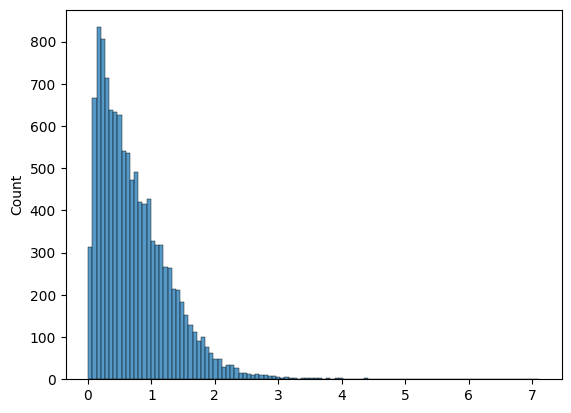

In [65]:
sns.histplot([edge['reprojected_err'] for edge in cam_marker_edges.values()])
# print the mean and std of the reprojected errors
print(np.mean([edge['reprojected_err'] for edge in cam_marker_edges.values()]),
      np.std([edge['reprojected_err'] for edge in cam_marker_edges.values()]))

# Optimization

In [81]:
# Optimization - see extended paper
pose_est = bipartite_se3sync(cam_marker_edges,
                             constraints=obj_pose_est,
                             noise_model_r=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1.0,
                             noise_model_t=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1.0,
                             edge_filter=lambda edge : edge['reprojected_err'] < 0.2,
                             maxiter=4,
                             lsqr_solver="conjugate_gradient",
                             dtype=np.float32)

Received graph with 5760 nodes 11735 edges
Applying constraints (0.130s).
Bipartite graph: 3 cameras, 773 timesteps, 1278 edges.
Building 3x773 adjacency and 9x2319 SO(3) sparse matrices (0.012s).
Building power graph (0.003s).


Optimizing:   0%|                                                                    | 0/4 [00:00<?, ?it/s]

Building sparse 5412x2328 incidence matrix (0.317s).
Solving sparse linear system (0.008s).
Done!


# Cameras D Plot

In [27]:
def plot_frame(ax, H, label):
    origin = H[:3, 3]
    x_axis = H[:3, 0]
    y_axis = H[:3, 1]
    z_axis = H[:3, 2]

    ax.quiver(*origin, *x_axis, color='r', length=0.1, normalize=True)
    ax.quiver(*origin, *y_axis, color='g', length=0.1, normalize=True)
    ax.quiver(*origin, *z_axis, color='b', length=0.1, normalize=True)
    ax.text(*origin, label, fontsize=12, color='k')

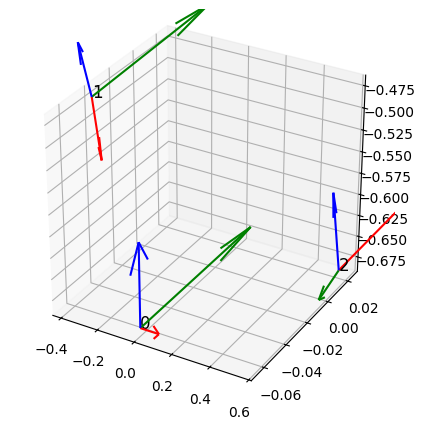

In [83]:
%matplotlib inline

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

for cam_id, pose in pose_est.items():
    if "_" in cam_id:
        continue
    #pose_est[cam_id] = pose_est[cam_id].inv() @ pose_est[wrl_idx]
    plot_frame(ax, pose_est[cam_id].A() , cam_id)

# aspect ratio of the plot to be equal
ax.set_box_aspect([1,1,1])

#make the plot interactive
plt.show()


In [85]:
for cam_id, cam in dataset.cams.items():
    cam.extrinsics = pose_est[cam_id]
    # draw axis of frames of each camera

plot_cams_3D(dataset.cams.values())    

"file:///home/manuelf/ist/smart_retail/vicandocker/file.html"

'file:///home/manuelf/ist/smart_retail/vicandocker/file.html'

In [90]:
import open3d as o3d

# Load the PCD file
pc0 = o3d.io.read_point_cloud("dataset/pointcloud0.pcd")
pc1 = o3d.io.read_point_cloud("dataset/pointcloud1.pcd")
pc2 = o3d.io.read_point_cloud("dataset/pointcloud2.pcd")

# transform point clouds to world frame
pc0.transform(pose_est['0'].inv().A())
pc1.transform(pose_est['1'].inv().A())
pc2.transform(pose_est['2'].inv().A())

# Visualize the point cloud
o3d.visualization.draw_geometries([pc0, pc1])


libGL error: MESA-LOADER: failed to retrieve device information
libGL error: MESA-LOADER: failed to open amdgpu: /usr/lib/dri/amdgpu_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri)
libGL error: failed to load driver: amdgpu
libGL error: failed to open /dev/dri/card0: No such file or directory
libGL error: failed to load driver: radeonsi


In [93]:
for cam_id, pose in pose_est.items():
    if "_" in cam_id:
        continue
    print(cam_id)
    print(pose)
    

0
[[ 1.      0.     -0.     -0.0075]
 [-0.      1.      0.     -0.0649]
 [-0.     -0.      1.     -0.6848]
 [ 0.      0.      0.      1.    ]]
1
[[ 0.7946  0.1474  0.589  -0.3787]
 [-0.0519  0.983  -0.1761 -0.0443]
 [-0.6049  0.1094  0.7887 -0.4677]
 [ 0.      0.      0.      1.    ]]
2
[[-0.0218 -0.9139 -0.4054  0.5453]
 [ 0.9998 -0.0215 -0.0054  0.0234]
 [-0.0038 -0.4054  0.9141 -0.6879]
 [ 0.      0.      0.      1.    ]]
